In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.plotters import plot_solution
from utils.data_loaders import read_solution

## [1] Load Data

In [2]:
SOLUTION = read_solution('data/raw/sintef_routes.txt')
locations = pd.read_csv('data/processed/c101.csv')
solution_locations = np.sum([len(route) for index, route in SOLUTION.items()])
print(f"Number of Locations in Customers[{len(locations)}], Solution[{solution_locations}]")
locations.head()

Number of Locations in Customers[101], Solution[100]


,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
0,1,40.0,50.0,0.0,0.0,1236.0,0.0
1,2,45.0,68.0,10.0,912.0,967.0,90.0
2,3,45.0,70.0,30.0,825.0,870.0,90.0
3,4,42.0,66.0,10.0,65.0,146.0,90.0
4,5,42.0,68.0,10.0,727.0,782.0,90.0


In [3]:
""" Descriptive Statistics of the Customers.
iloc[1:] is used to exclude the depot from the statistics.
"""
locations.iloc[1:].describe()

,CustomerNO,Lng,Lat,Demand,ReadyTime,Due,ServiceTime
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,51.500000,42.300000,48.590000,18.100000,426.800000,487.560000,90.0
std,29.011492,22.977591,21.367915,10.415121,282.203738,282.053198,0.0
min,2.000000,0.000000,5.000000,10.000000,10.000000,67.000000,90.0
25%,26.750000,25.000000,32.000000,10.000000,177.500000,237.750000,90.0
50%,51.500000,40.000000,47.500000,10.000000,417.500000,480.000000,90.0
75%,76.250000,58.500000,66.000000,20.000000,645.500000,710.000000,90.0
max,101.000000,95.000000,85.000000,50.000000,1054.000000,1127.000000,90.0


## [1.1] Optimal Solution

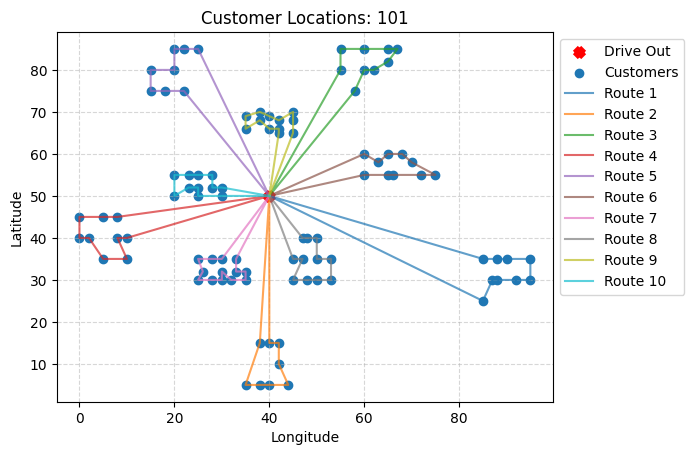

In [4]:
plot_solution(locations, SOLUTION)

## [2] Preprocessing

### [2.1] Remove origin
This dataset consists of 100 customers. But as you can see above, we currently have 101 rows. This is because the first index is the 'Driveout' location / 'Origin'. Thus, we need to remove this from the customers_data.

In [5]:
origin = locations.iloc[0]

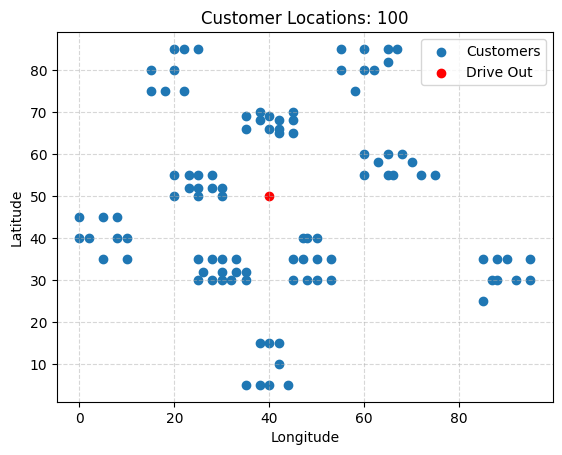

In [6]:
plt.title(f'Customer Locations: {len(locations) - 1}')
plt.scatter(locations.iloc[1:]['Lng'], locations.iloc[1:]['Lat'])
plt.scatter(origin['Lng'], origin['Lat'], color='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(['Customers', 'Drive Out'])
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## [3] Problem

**REFERENCES**

Mirjalili, Ali, *Youtube*, https://www.youtube.com/watch?v=783ZtAF4j5g
(Cannot use graphs, must use matrixes for the mathematical modelling)[11:30]

• Depot: The starting and ending point for all vehicles. 
• Customers: Each customer has a location, a demand for goods, a time window for 
receiving the delivery, and a service time. 
• Vehicles:  Each  vehicle  has  a  limited  capacity  and  must  return  to  the  depot  after 
completing its route. 

### [3.1] Constraints
1. Each customer is visited exactly once by one vehicle. 
2. Deliveries occur within the specified time windows. 
3. The total demand on any route does not exceed the vehicle's capacity.

## Constants

In [7]:
ALPHA = .7
BETA = .3
NUMBER_OF_ANTS = 10
NUMBER_OF_ITERATIONS = 10

VEHICLE_CAPACITY = 200

### Ant move to node probability formula
**We should set allowed to only be the most near neighbours**

$$P_{ij}(t) =\frac{[\tau_{ij}(t)]^\alpha * [n_{ij}]^\beta}{\sum_{k \in allowed}[\tau_{ik}(t)]^\alpha * [n_{ik}]^\beta}$$

In [8]:
from typing import List, Callable

@staticmethod
def calculate_probability_at_node(i: int, j: int, allowed: List[int], pheromone: np.ndarray, distance: np.ndarray, alpha: float, beta: float) -> float:
    objective = (distance[i, j] ** beta)
    nominator = (pheromone[i, j] ** alpha) * objective
    denominator = np.array((pheromone[i, k] ** alpha) * (distance[i, k] ** beta) for k in allowed).sum()
    return nominator / denominator

@staticmethod
def calculate_probabilities(current_node: int, allowed: List[int], pheromone: np.ndarray, distance: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    return np.array([calculate_probability_at_node(current_node, j, allowed, pheromone, distance, alpha, beta) for j in allowed])

@staticmethod
def roulette_wheel_selection(probabilities: np.ndarray) -> int:
    cumulative_sum = np.cumsum(probabilities)
    print(f"Cumulative Sum: {cumulative_sum}")
    random_number = np.random.rand()
    print(f"Random Number: {random_number}")
    for index, cumulative_prob in enumerate(cumulative_sum):
        if random_number <= cumulative_prob:
            print(f"Selected Node: {index}")
            return index
    return -1

In [15]:
from numpy.typing import NDArray

class Customer:
    def __init__(self,
                 customer_no: int, demand: float,
                 lat: float, lng: float,
                 ready_time: float, due_time: float,
                 service_time: float):
        self.customer_no: int = int(customer_no - 1)
        self.demand = demand
        self.lat = lat
        self.lng = lng
        self.ready_time = ready_time
        self.due_time = due_time
        self.service_time = service_time
        self.completed = False

    @staticmethod
    def from_series(series: pd.Series) -> 'Customer':
        return Customer(
            customer_no=series['CustomerNO'],
            demand=series['Demand'],
            lat=series['Lat'],
            lng=series['Lng'],
            ready_time=series['ReadyTime'],
            due_time=series['Due'],
            service_time=series['ServiceTime']
        )
    
    def distance(self, other: 'Customer') -> float:
        return np.sqrt((self.lat - other.lat)**2 + (self.lng - other.lng)**2)
    
    def complete(self) -> None:
        self.completed = True
    
    def is_completed(self) -> bool:
        return self.completed
        
    def __eq__(self, other: 'Customer') -> bool:
        return self.customer_no == other.customer_no
    
    def __repr__(self) -> str:
        return f"Customer({self.customer_no})"


class Customers:
    def __init__(self, data: pd.DataFrame):
        self.customers = self.__create_customers(data)

    def get_distance_table(self) -> NDArray[np.float64]:
        return np.array([[customer.distance(other) for other in self.customers] for customer in self.customers])
    
    def get_not_completed(self) -> List[Customer]:
        return [customer for customer in self.customers if not customer.is_completed()]
    
    def all_completed(self) -> bool:
        return all(customer.is_completed() for customer in self.customers)

    def __create_customers(self, data: pd.DataFrame) -> List[Customer]:
        customers = [Customer.from_series(row) for _, row in data.iterrows()]
        return customers

    def __len__(self) -> int:
        return len(self.customers)
    
    def __iter__(self):
        return iter(self.customers)
    
    def __getitem__(self, val: int) -> Customer:
        return self.customers[val]


class Vehicle:
    def __init__(self, id: int, capacity: int, depot: Customer):
        self.id = id
        self.capacity = capacity
        self.load = 0

        self.depot = depot
        self.route = [depot]
        self.current_customer = depot
        self.current_time = 0
        self.total_distance = 0
        self.started = False
        self.is_retired = False
    
    def find_next_customer(self, outstanding_customers: list[Customer], pheromone: NDArray[np.float64], distance: NDArray[np.float64], alpha: float, beta: float) -> Customer:
        allowed_customers = [customer for customer in outstanding_customers if customer not in self.route]

        if len(allowed_customers) == 0:
            self.is_retired = True
            return self.depot
        
        if len(allowed_customers) == 1:
            return allowed_customers[0]

        def calculate_probability_at_node(i: int, j: int, allowed: List[int], pheromone: np.ndarray, distance: np.ndarray, alpha: float, beta: float) -> float:
            objective = (distance[i, j] ** beta)
            nominator = (pheromone[i, j] ** alpha) * objective
            denominator = np.array([(pheromone[i, k] ** alpha) * (distance[i, k] ** beta) for k in allowed]).sum()
            return nominator / denominator

        allowed_indices = [customer.customer_no for customer in allowed_customers]
        probabilities = [calculate_probability_at_node(self.current_customer.customer_no, j, allowed_indices, pheromone, distance, alpha, beta) for j in allowed_indices]

        cumulative_sum = np.cumsum(probabilities)
        print(f"Cumulative Sum: {cumulative_sum}")

        random_number = np.random.rand()
        print(f"Random Number: {random_number}")

        node = - 1
        for index, cumulative_prob in enumerate(cumulative_sum):
            if random_number <= cumulative_prob:
                print(f"Selected Node: {index}")
                node = index
        
        assert node != -1, "No node was selected."

        return outstanding_customers[node]
        
    def is_at_depot(self) -> bool:
        return self.current_customer == self.depot

    def add_customer(self, customer: Customer) -> None:
        # Ensure the vehicle can do the customer
        assert not self.can_do_customer(customer), f"Cannot add customer {customer.customer_no} to the route."

        if not self.started:
            self.started = True

        self.route.append(customer)
        self.current_customer = customer

        self.load += customer.demand
        self.total_distance += self.current_customer.distance(customer)

        # Does not account for waiting time (such as driving distance to the customer)
        self.current_time += customer.service_time
    
    def can_do_customer(self, customer: Customer) -> bool:
        return self.has_capacity(customer) and self.is_within_time_window(customer)

    def has_capacity(self, customer: Customer) -> bool:
        return self.load + customer.demand <= self.capacity

    def is_within_time_window(self, customer: Customer) -> bool:
        return self.current_time >= customer.ready_time \
            and self.current_time + customer.service_time <= customer.due_time \
            and self.can_do_within_shift(customer)

    def can_do_within_shift(self, customer: Customer) -> bool:
        return self.current_time + customer.service_time <= self.depot.due_time 
    
    def __len__(self) -> int:
        """ Gets the number of customers in the route.

        Returns:
            int: Number of customers in the route. 
        """
        return len(self.route)

In [25]:
VEHICLES = 10

customers = Customers(locations)
depot = customers[0]
print(f"Depot: {depot.customer_no}")
assert depot.customer_no == 0, "Depot is not the first customer."

distance_table = customers.get_distance_table()
print(f"Distance Table: {distance_table.shape}, dtype: {distance_table.dtype}")
pheromones = np.ones(distance_table.shape)
print(f"Pheromone Table: {pheromones.shape}, dtype: {pheromones.dtype}")

vehicles = [Vehicle(id + 1, VEHICLE_CAPACITY, depot) for id in range(VEHICLES)]

customer_pool = customers.customers[1:]

assert all(vehicle.is_at_depot() for vehicle in vehicles), "All vehicles are not starting at the depot.[Constraint Violation]"
assert all(vehicle.load == 0 for vehicle in vehicles), "All vehicles do not have a load of 0."
assert all(vehicle.started == False for vehicle in vehicles), "Some Vehicles have started."
assert not customers.all_completed(), "All customers are already completed."

# TODO: Might want to just assign a random customer to each vehicle.

for iter in range(100):
    print(f"Iteration {iter}")

    if all(vehicle.is_retired for vehicle in vehicles):
        break

    if len(customer_pool) <= 0:
        print("No more customers to add.")
        break

    for vehicle in vehicles:
        if vehicle.is_retired:
            if not vehicle.is_at_depot():
                vehicle.add_customer(depot)
                continue
            continue

        # if vehicle.is_at_depot() and not vehicle.started:
        #     next_customer = vehicle.find_next_customer(customer_pool, pheromones, distance_table, ALPHA, BETA)

        #     if next_customer == depot:
        #         continue

        #     vehicle.add_customer(next_customer)
        #     customer_pool.remove(next_customer)
            
        next_customer = vehicle.find_next_customer(customer_pool, pheromones, distance_table, ALPHA, BETA)
        print(f"Next Customer: {next_customer.customer_no}")
        vehicle.add_customer(next_customer)

        if next_customer == depot:
            continue

        customer_pool.remove(next_customer)

for vehicle in vehicles:
    if not vehicle.is_at_depot():
        vehicle.route.append(depot)
print(vehicles[0].route)

Depot: 0
Distance Table: (101, 101), dtype: float64
Pheromone Table: (101, 101), dtype: float64
Iteration 0
Cumulative Sum: [0.00894721 0.01816278 0.02672349 0.03558779 0.04398702 0.05297971
 0.06152054 0.07038484 0.07953063 0.08819166 0.09727513 0.10835333
 0.11874903 0.12993752 0.14083573 0.1521049  0.16274641 0.1735807
 0.18474301 0.19216062 0.19962199 0.20748888 0.21551391 0.22389096
 0.23229019 0.24080068 0.24951621 0.25832271 0.26745485 0.27667042
 0.28733483 0.29781247 0.30847546 0.31902856 0.33010675 0.34094104
 0.3521241  0.3634698  0.37473896 0.38395453 0.39290174 0.40193865
 0.41056698 0.41990471 0.42934769 0.43856001 0.44741211 0.45697531
 0.46599762 0.47549633 0.48526073 0.49455565 0.50621677 0.51746397
 0.52827075 0.53991812 0.55071962 0.56237043 0.57317721 0.58484603
 0.59428902 0.60314111 0.61137146 0.6207092  0.62869816 0.63732648
 0.64520132 0.65441689 0.66292738 0.67553006 0.68803398 0.69766186
 0.71007987 0.71919134 0.72770183 0.73987963 0.7520433  0.76408551
 0.776

In [28]:
for vehicle in vehicles:
    print(f"Vehicle {vehicle.id} - Load: {vehicle.load}, Distance: {vehicle.total_distance}, Route: {vehicle.route}")

Vehicle 1 - Load: 140.0, Distance: 0.0, Route: [Customer(0), Customer(100), Customer(90), Customer(80), Customer(70), Customer(60), Customer(50), Customer(40), Customer(30), Customer(20), Customer(10), Customer(0)]
Vehicle 2 - Load: 110.0, Distance: 0.0, Route: [Customer(0), Customer(99), Customer(89), Customer(79), Customer(69), Customer(59), Customer(49), Customer(39), Customer(29), Customer(19), Customer(9), Customer(0)]
Vehicle 3 - Load: 210.0, Distance: 0.0, Route: [Customer(0), Customer(98), Customer(88), Customer(78), Customer(68), Customer(58), Customer(48), Customer(38), Customer(28), Customer(18), Customer(8), Customer(0)]
Vehicle 4 - Load: 190.0, Distance: 0.0, Route: [Customer(0), Customer(97), Customer(87), Customer(77), Customer(67), Customer(57), Customer(47), Customer(37), Customer(27), Customer(17), Customer(7), Customer(0)]
Vehicle 5 - Load: 180.0, Distance: 0.0, Route: [Customer(0), Customer(96), Customer(86), Customer(76), Customer(66), Customer(56), Customer(46), C

In [29]:
print(SOLUTION)

{'1': array([81, 78, 76, 71, 70, 73, 77, 79, 80]), '2': array([57, 55, 54, 53, 56, 58, 60, 59]), '3': array([ 98,  96,  95,  94,  92,  93,  97, 100,  99]), '4': array([32, 33, 31, 35, 37, 38, 39, 36, 34]), '5': array([13, 17, 18, 19, 15, 16, 14, 12]), '6': array([90, 87, 86, 83, 82, 84, 85, 88, 89, 91]), '7': array([43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 49, 47]), '8': array([67, 65, 63, 62, 74, 72, 61, 64, 68, 66, 69]), '9': array([ 5,  3,  7,  8, 10, 11,  9,  6,  4,  2,  1, 75]), '10': array([20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21])}


In [12]:
class Ant:
    def __init__(self, starting_node: int, end_node: int):
        self.alpha = ALPHA
        self.beta = BETA
        self.traversed_path = []
        self.current_node = starting_node

        # One of the Constraints.
        self.start_location = starting_node
        self.end_location = end_node 

    def move(self, pheromone_matrix: np.ndarray, distance_matrix: np.ndarray, alpha: float, beta: float):
        """ Move the ant to the next node based on the pheromone and distance matrix(n_{ij}).
        n_{ij} = Objective -> Domain Knowledge

        Args:
            pheromone_matrix (np.ndarray): The matrix containing the pheromone values between all nodes in the network.
            distance_matrix (np.ndarray): The matrix containing the distance values between all nodes in the network.
            alpha (float): Value to control the influence of the pheromone matrix. (tau_{ij})
            beta (float): Value to control the influence of the distance matrix. (n_{ij})
        """
        allowed_nodes = self.get_allowed_nodes()

        # If there are no allowed nodes, move to the end location.
        if not allowed_nodes:
            self.current_node = self.end_location
            return

        node_probabilities = calculate_probabilities(self.current_node, allowed_nodes, pheromone_matrix, distance_matrix, alpha, beta)
        next_node = roulette_wheel_selection(node_probabilities)

        assert next_node != -1, "No node was selected."

        self.current_node = next_node
    
    def get_allowed_nodes(self):
        """ Get the nodes that the ant has not visited yet and can move to.
        Here can we also add constraints etc.
        """
        return [node for node in range(len(pheromone_matrix)) if node not in self.traversed_path]



class Colony:
    def __init__(self, pheromone_matrix: np.ndarray, objectives: List[Callable[[pd.Series, pd.Series], float]]):
        self.objective_functions = objectives
        self.pheromones = pheromone_matrix

    def create_ants(self, start_end_location: int) -> List[Ant]:
        """
        Create a list of ants with random starting locations.
        *TODO: Should start at the origin and end at the origin.*
        """
        ants = [Ant(start_end_location, start_end_location) for location in range(pheromone_matrix.shape[0]) if location != start_end_location]
        return ants

    def run(self, number_of_iterations: int, start_end_location: int):
        for _ in range(number_of_iterations):
            ants = self.create_ants(start_end_location)
            for ant in ants[-1:]:
                ant.move(self.pheromones, distance_matrix, ALPHA, BETA)

colony = Colony(pheromone_matrix, [functions.calculate_distance])
colony.run(1, 0)


NameError: name 'pheromone_matrix' is not defined

### [3.2] Cost Matrix

### [3.3] Pheromone Matrix